园区车流量预测模型(直流充电桩曲线构建)

用户可设置参量：

```python
N_c = 1500  #EV的数量，每次仿真中EV的为用户输入
S_EV_samples = S_EV0_samples - (m_samples * np.random.choice(E_b, size=N_c,p=[0.25,0.25,0.5])) / (E_h * 100) #p对应的不同季节的比例


In [13]:
import numpy as np
from scipy.stats import lognorm, uniform, norm
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd

# # 使用本地文件路径显示图片
# Image(filename='E:\\大学竞赛\\2025高校电气电子创新竞赛\\园区车辆负荷预测参数.png', width=400)

EV单日行驶里程m的概率密度函数满足对数正态分布：
$f(m) = \frac{1}{m\sigma\sqrt{2\pi}} \exp\left(-\frac{(\ln m - \mu)^2}{2\sigma^2}\right)$

EV的初始SOC满足均匀分布：
$f(S_{EV}^0) = \frac{1}{b-a}$
其中$b$，$a$分别是SOC的上下限。

行驶至光储充园区时的SOC为：
$S_{EV} = S_{EV}^0 - \left(\frac{m \cdot E_b}{E_h \cdot 100}\right)$
其中$m$为行驶里程，$E_b$为百公里电耗，$E_h$为电池总容量。

一天时间里EV行驶经过光储充园区的时间$T_s$满足正态分布：
$f(T_s) = \frac{1}{\sigma_c \sqrt{2\pi}} \exp\left(-\frac{(T_s-\mu_c)^2}{2\sigma_c^2}\right)$

则EV通过直流充电桩的充电时长$T_c$为：
$T_c = \left(\frac{1-S_{EV}}{P_{EV} \cdot \eta}\right) \cdot E_h$
其中$P_{EV}$为充电功率，$\eta$为充电效率。

因此，通过蒙特卡洛法建模，单个EV的逐时充电功率为：
$P_{EV}(t) = 
  \begin{cases} 
   P_{che}, & \text{if } T_s \leq t \leq T_s + T_c \\
   0, & \text{otherwise}
  \end{cases}
$

通过对大量 EV 的行为（出行时间、SOC、电量需求）进行仿真，累计多个 EV 的充电功率，得到某一典型日的负荷曲线：
$\bar{P}_{EV}(t) = \frac{1}{M} \sum_{j=1}^{M} \sum_{i=1}^{N_j} P_{EV}^{i,j}(t)$
其中$M$为蒙特卡洛仿真次数，$N_j$为第$j$次仿真中的 EV 数量。

参数设置与初始化

In [14]:

# 参数设置
mu_l = 3.2  # 行驶里程m的对数正态分布的均值
sigma_l = 0.88  # 行驶里程m的对数正态分布的标准差
a = 0.8  # 初始SOC的下限
b = 1  # 初始SOC的上限
mu_c = [10.50, 19.00]  # 经过光储充园区时间的正态分布均值 (小时) 上午和下午
sigma_c = [2.14, 3.14]  # 经过光储充园区时间的正态分布标准差 (小时) 上午和下午
# P_che = [7, 60]  # 充电功率 (kW) 慢充和快充
P_che = [120]
eta = 0.90  # 充电效率
E_h = 80  # 电池总容量 (kWh)
E_b = [20.54, 18.89, 20]  # 百公里电耗 (kWh/100km) 冬季、夏季和过渡季

# 蒙特卡洛仿真次数和每次仿真中的EV数量
M_c = 30
N_c = 1000  #EV的数量，每次仿真中EV的为用户输入

In [15]:
# 时间设置
time_steps = np.arange(0, 24, 0.01)  # 时间步长为0.1小时
num_time_steps = len(time_steps)
print(num_time_steps)

# 初始化总负荷矩阵
total_load_matrix = np.zeros((M_c, num_time_steps))
print(total_load_matrix)

total_num_matrix   = np.zeros((M_c, num_time_steps))    # NEW ▶ 并发数量矩阵

2400
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


蒙特卡洛仿真

In [16]:
# 蒙特卡洛仿真
for j in range(M_c):
    # 生成随机样本
    m_samples = lognorm.rvs(s=sigma_l, scale=np.exp(mu_l), size=N_c)  # 行驶里程样本
    m_samples = np.clip(m_samples, 0, np.inf)  # 限制行驶里程在0以上
    S_EV0_samples = uniform.rvs(loc=a, scale=b-a, size=N_c)  # 初始SOC样本
    T_s_samples = []
    for i in range(N_c):
        if i % 2 == 0:  # 上午
            T_s_samples.append(norm.rvs(loc=mu_c[0], scale=sigma_c[0]))
        else:  # 下午
            T_s_samples.append(norm.rvs(loc=mu_c[1], scale=sigma_c[1]))
    T_s_samples = np.clip(T_s_samples, 0, 24)  # 限制时间在0到24小时之间

    # 计算到达光储充园区时的SOC
    S_EV_samples = S_EV0_samples - (m_samples * np.random.choice(E_b, size=N_c,p=[0.25,0.25,0.5])) / (E_h * 100)
    #这里的p也是用户设置的一个参数，表示不同季节的比例（针对典型日的设计是这样的，如果不是典型日，则只有一个选择其实）
    S_EV_samples = np.clip(S_EV_samples, 0, 1)  # 确保SOC在0到1之间

    # 计算充电时长
    T_c_samples = ((1 - S_EV_samples) * E_h) / (np.random.choice(P_che, size=N_c) * eta)

    # 计算逐时充电功率
    P_EV_matrix = np.zeros((N_c, num_time_steps))

    for i in range(N_c):
        T_s = T_s_samples[i]
        T_c = T_c_samples[i]
        start_idx = int(np.round(T_s / 0.01))  # 起始时间索引
        end_idx = int(np.round((T_s + T_c) / 0.01))  # 结束时间索引
        if start_idx < num_time_steps and end_idx < num_time_steps:
            P_EV_matrix[i, start_idx:end_idx] = np.random.choice(P_che)

    # 累计本次仿真的总负荷
    total_load_matrix[j, :] = np.sum(P_EV_matrix, axis=0)
    total_num_matrix[j, :]  = (P_EV_matrix > 0).sum(axis=0)   # NEW ▶
# 计算平均负荷曲线
average_load_curve = np.mean(total_load_matrix, axis=0)
average_num_curve  = total_num_matrix.mean(axis=0)            # NEW ▶
# ───── 车流量峰值统计 ─────
peak_num = int(average_num_curve.max())                      # NEW ▶
peak_time_idx = average_num_curve.argmax()                   # NEW ▶
peak_time = time_steps[peak_time_idx]                    # NEW ▶

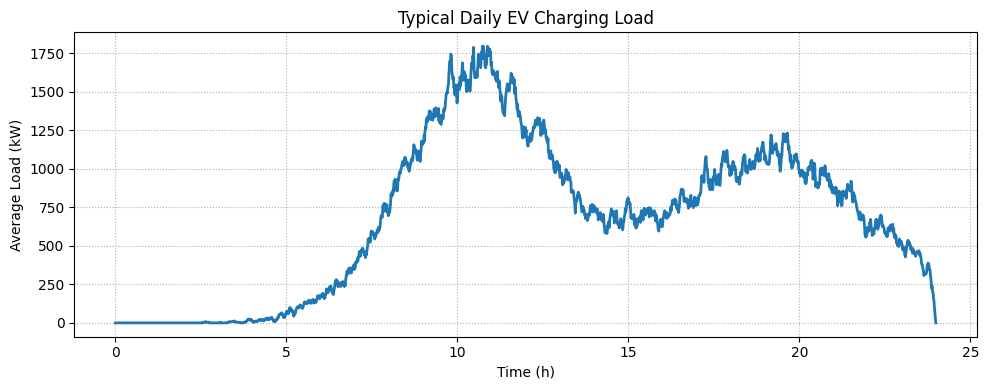

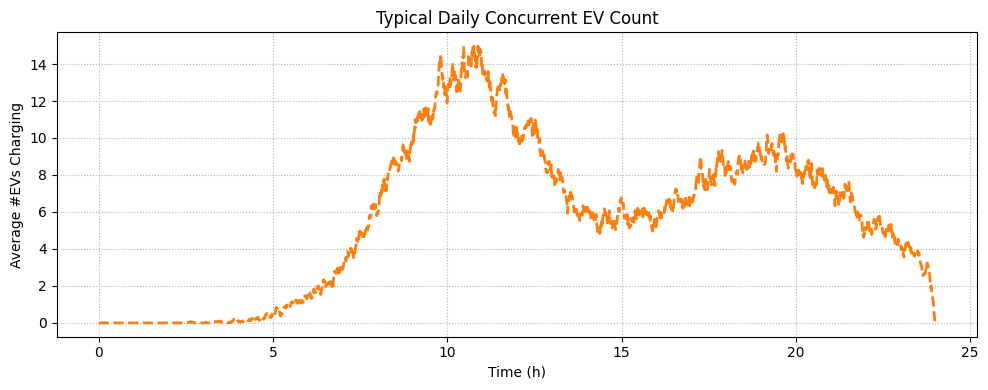

In [17]:

# # 绘制典型日负荷曲线
# plt.figure(figsize=(10, 6))
# plt.plot(time_steps, average_load_curve, label='Average Load Curve (kW)')
# plt.xlabel('Time (hours)')
# plt.ylabel('Load (kW)')
# plt.title('Typical Daily Load Curve of EV Charging')
# plt.legend()
# plt.grid(True)
# plt.show()
# ───── 绘图（两张独立图） ─────
plt.figure(figsize=(10, 4))
plt.plot(time_steps, average_load_curve, linewidth=2)
plt.xlabel('Time (h)'); plt.ylabel('Average Load (kW)')
plt.title('Typical Daily EV Charging Load')
plt.grid(True, linestyle=':')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 4))
plt.plot(time_steps, average_num_curve, linewidth=2, linestyle='--', color='tab:orange')
plt.xlabel('Time (h)'); plt.ylabel('Average #EVs Charging')
plt.title('Typical Daily Concurrent EV Count')
plt.grid(True, linestyle=':')
plt.tight_layout(); plt.show()

In [18]:
# # 将数据导出为CSV
# # 创建DataFrame
# time_steps_df = pd.DataFrame(time_steps, columns=["Time (hours)"])
# average_load_df = pd.DataFrame(average_load_curve, columns=["Average Load (kW)"])
# total_load_matrix_df = pd.DataFrame(total_load_matrix.T, columns=[f"Simulation {i+1}" for i in range(M_c)])

# # 合并数据
# combined_df = pd.concat([time_steps_df, average_load_df, total_load_matrix_df], axis=1)

# # 导出为CSV文件
# combined_df.to_csv("load_simulation_results.csv", index=False)

# print("数据已成功导出到 load_simulation_results.csv 文件中。")

# ───── 导出两个 CSV ─────
# ① 负荷数据
df_time        = pd.DataFrame(time_steps, columns=['Time (h)'])
df_avg_load    = pd.DataFrame(average_load_curve, columns=['Avg_Load_kW'])
df_load_sims   = pd.DataFrame(total_load_matrix.T,
                              columns=[f'Load_Sim_{i+1}' for i in range(M_c)])
load_df        = pd.concat([df_time, df_avg_load, df_load_sims], axis=1)
load_df.to_csv('load_results.csv', index=False)

# ② 并发数量数据
df_avg_num     = pd.DataFrame(average_num_curve, columns=['Avg_Num_EVs'])
df_num_sims    = pd.DataFrame(total_num_matrix.T,
                              columns=[f'Num_Sim_{i+1}' for i in range(M_c)])
num_df         = pd.concat([df_time, df_avg_num, df_num_sims], axis=1)
num_df.to_csv('num_results.csv', index=False)
print(f'车流量峰值发生在 {peak_time:.2f} h ，同时有 {peak_num} 辆车在充电')   # NEW ▶
print('✅ 已分别导出：load_results.csv  和  num_results.csv')

车流量峰值发生在 10.73 h ，同时有 14 辆车在充电
✅ 已分别导出：load_results.csv  和  num_results.csv
